In [1]:
"""
Visualize convolution layers of JTE607_CNN-DLinstance-logratio_25nt_mixedsort-4120-batchnorm-07-25-2022-6epoch_x10.ipynb
Trial 6 with all data performed the best, so visualizing its layers here

Based off of APARENT code
https://nbviewer.org/github/johli/aparent/blob/master/analysis/analyze_aparent_conv_layers_alien1_legacy.ipynb
"""

from __future__ import print_function

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model

from scipy.stats import pearsonr

import seaborn as sns

In [2]:
"""
Code copied from here, and slightly modified:
https://github.com/johli/aparent/blob/master/analysis/analyze_aparent_conv_layers_helpers.py
"""
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import isolearn.io as isoio

from scipy.stats import pearsonr

import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

#Sequence Plotting Functions

def letterAt(letter, x, y, yscale=1, ax=None, color=None, alpha=1.0):

    #fp = FontProperties(family="Arial", weight="bold")
    fp = FontProperties(family="Ubuntu", weight="bold")
    globscale = 1.35
    LETTERS = {	"T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
                "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
                "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
                "C" : TextPath((-0.366, 0), "C", size=1, prop=fp),
                "UP" : TextPath((-0.488, 0), '$\\Uparrow$', size=1, prop=fp),
                "DN" : TextPath((-0.488, 0), '$\\Downarrow$', size=1, prop=fp),
                "(" : TextPath((-0.25, 0), "(", size=1, prop=fp),
                "." : TextPath((-0.125, 0), "-", size=1, prop=fp),
                ")" : TextPath((-0.1, 0), ")", size=1, prop=fp)}
    COLOR_SCHEME = {'G': 'orange', 
                    'A': 'red', 
                    'C': 'blue', 
                    'T': 'darkgreen',
                    'UP': 'green', 
                    'DN': 'red',
                    '(': 'black',
                    '.': 'black', 
                    ')': 'black'}


    text = LETTERS[letter]

    chosen_color = COLOR_SCHEME[letter]
    if color is not None :
        chosen_color = color

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=chosen_color, alpha=alpha, transform=t)
    if ax != None:
        ax.add_artist(p)
    return p



def plot_pwm_iso_logo(pwms, r_vals, k, logo_ax, corr_ax, seq_start=4, seq_end=101, SVLst_cs_start=49) :
    #Make sequence logo
    pwm = pwms[k]
    
    entropy = np.zeros(pwm.shape)
    entropy[pwm > 0] = pwm[pwm > 0] * -np.log2(pwm[pwm > 0])
    entropy = np.sum(entropy, axis=1)
    conservation = 2 - entropy

    height_base = 0.0
    logo_height = 1.0
    
    for j in range(pwm.shape[0]) :
        sort_index = np.argsort(pwm[j, :])

        for ii in range(0, 4) :
            i = sort_index[ii]

            nt_prob = pwm[j, i] * conservation[j]

            nt = ''
            if i == 0 :
                nt = 'A'
            elif i == 1 :
                nt = 'C'
            elif i == 2 :
                nt = 'G'
            elif i == 3 :
                nt = 'T'

            if ii == 0 :
                letterAt(nt, j + 0.5, height_base, nt_prob * logo_height, logo_ax, color=None)
            else :
                prev_prob = np.sum(pwm[j, sort_index[:ii]] * conservation[j]) * logo_height
                letterAt(nt, j + 0.5, height_base + prev_prob, nt_prob * logo_height, logo_ax, color=None)

    plt.sca(logo_ax)
    plt.xlim((0, pwm.shape[0]))
    plt.ylim((0, 2))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.axis('off')
    logo_ax.axhline(y=0.01 + height_base, color='black', linestyle='-', linewidth=2)
    
    #Make correlation map
    r_val_vec = r_vals[k, seq_start: seq_end].reshape(1, -1)
    corr_ax.imshow(r_val_vec, cmap='RdBu_r', aspect='auto', vmin=-np.max(np.abs(r_vals[:, seq_start: seq_end])), vmax=np.max(np.abs(r_vals[:, seq_start: seq_end])))

    plt.sca(corr_ax)
    plt.xticks([SVLst_cs_start - seq_start], ['Start of SVLst designed cut site'], fontsize=12)
    plt.yticks([], [])



In [3]:
"""
Load data
"""

output_data_dir = "/JTE-607/Analysis/Revisions_1/models_25nt_logratio_mixedsort_4120_batchnorm-SVLstonly/data_splits/"
output_fig_dir = "/JTE-607/Analysis/Figures/Revisions_1/JTE607_CNN_25nt_6epoch_4col_model-SVLstonly_6/"

data_train_x = pickle.load(open(output_data_dir + "seq_e_train.p", "rb"))
#data_train_y = pickle.load(open(output_data_dir + "res_train.p", "rb"))
#data_test_x = pickle.load(open(output_data_dir + "seq_e_test.p", "rb"))
#data_test_y = pickle.load(open(output_data_dir + "res_test.p", "rb"))


In [4]:
"""
Load best performing model with all data
"""

all_doses_trial_num = 6
models_dir = "/JTE-607/Analysis/Revisions_1/models_25nt_logratio_mixedsort_4120_batchnorm-SVLstonly/"
C3P0_ratios_model_SVLstonly = load_model("%s/JTE607_CNN_25nt_6epoch_4col_model_%s.hdf5" % (models_dir, all_doses_trial_num))


[2023-05-04 22:14:07.745 ip-172-31-11-19.us-west-1.compute.internal:18091 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-05-04 22:14:07.768 ip-172-31-11-19.us-west-1.compute.internal:18091 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


In [5]:
print(C3P0_ratios_model_SVLstonly.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 25, 120)           3960      
_________________________________________________________________
batch_normalization_40 (Batc (None, 25, 120)           480       
_________________________________________________________________
re_lu_30 (ReLU)              (None, 25, 120)           0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 25, 120)           115320    
_________________________________________________________________
batch_normalization_41 (Batc (None, 25, 120)           480       
_________________________________________________________________
re_lu_31 (ReLU)              (None, 25, 120)           0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 25, 120)         

In [6]:
print(C3P0_ratios_model_SVLstonly.inputs)
print(C3P0_ratios_model_SVLstonly.get_layer("conv1d_30"))
print(C3P0_ratios_model_SVLstonly.get_layer("re_lu_30"))

[<tf.Tensor 'conv1d_30_input:0' shape=(None, 25, 4) dtype=float32>]


In [7]:
"""
Create new model that outputs the convolutional layer 1 activation maps together with the log(ratio) predictions
"""

conv_layer_logratio_model = Model(
    inputs = C3P0_ratios_model_SVLstonly.inputs,
    outputs = [
        C3P0_ratios_model_SVLstonly.get_layer('conv1d_30').output,
        C3P0_ratios_model_SVLstonly.get_layer('dense_21').output
    ]
)

In [8]:
"""
Predict using convolutional layer activation model
"""
#Retrieve one-hot input sequences
onehot_seqs = data_train_x

ratio_conv_1_out, ratio_pred = conv_layer_logratio_model.predict(onehot_seqs, workers=4, use_multiprocessing=True)

print(ratio_conv_1_out.shape)

ratio_conv_1_out = np.reshape(ratio_conv_1_out, (ratio_conv_1_out.shape[0], ratio_conv_1_out.shape[1], ratio_conv_1_out.shape[2]))

print(onehot_seqs.shape)
print(ratio_pred)
print(ratio_conv_1_out.shape)

(100958, 25, 120)
(100958, 25, 4)
[[-0.02822695  0.04701005  0.07803788]
 [-0.07389697 -0.08124356 -0.10407057]
 [ 0.12786695  0.24233249  0.42592165]
 ...
 [-0.22552347 -0.2689769  -0.32126534]
 [ 0.1317293   0.23789236  0.43165472]
 [-0.14658639 -0.302867   -0.58694047]]
(100958, 25, 120)


In [9]:
#Layer 1: Compute Max Activation Correlation maps and PWMs, handle border_mode=same
filter_width = 8
n_samples = 5000

pwms = np.zeros((ratio_conv_1_out.shape[2], filter_width, 4))  # <num filters, filter_len, 4 nts>
pwms_top = np.zeros((ratio_conv_1_out.shape[2], filter_width, 4))

print("pwms.shape = ", pwms.shape)
print("onehot_seqs.shape = ", onehot_seqs.shape)
print("ratio_conv_1_out.shape = ", ratio_conv_1_out.shape)

filler_5 = np.zeros((3, 4))
filler_3 = np.zeros((4, 4))

for k in range(ratio_conv_1_out.shape[2]) :  # iterate over filters
    
    for i in range(ratio_conv_1_out.shape[0]) :  # iterate over samples
        max_j = np.argmax(ratio_conv_1_out[i, :, k])  # find max activation in seq
        if ratio_conv_1_out[i, max_j, k] > 0 :
            padded_one_hot = np.concatenate((filler_5, onehot_seqs[i, :, :], filler_3), axis=0)
            subseq_one_hot = padded_one_hot[max_j : max_j + filter_width, :]
            pwms[k, :, :] += subseq_one_hot

    sort_index = np.argsort(np.max(ratio_conv_1_out[:, :, k], axis=-1))[::-1]
    for i in range(n_samples) :  # iterate over samples that have been sorted
        max_j = np.argmax(ratio_conv_1_out[sort_index[i], :, k])
        if ratio_conv_1_out[sort_index[i], max_j, k] > 0 :
            padded_one_hot = np.concatenate((filler_5, onehot_seqs[sort_index[i], :, :], filler_3), axis=0)
            subseq_one_hot = padded_one_hot[max_j: max_j+filter_width, :]
            
            pwms_top[k, :, :] += subseq_one_hot
        
    pwms[k, :, :] /= np.expand_dims(np.sum(pwms[k, :, :], axis=-1), axis=-1)
    pwms_top[k, :, :] /= np.expand_dims(np.sum(pwms_top[k, :, :], axis=-1), axis=-1)

#print("pwms = ", pwms)
print("pwms.shape = ", pwms.shape)
print("(pwms == pwms_top).all() = ", (pwms == pwms_top).all())


r_vals_12p5 = np.zeros((ratio_conv_1_out.shape[2], ratio_conv_1_out.shape[1]))
r_vals_2p5 = np.zeros((ratio_conv_1_out.shape[2], ratio_conv_1_out.shape[1]))
r_vals_0p5 = np.zeros((ratio_conv_1_out.shape[2], ratio_conv_1_out.shape[1]))

for k in range(ratio_conv_1_out.shape[2]) :  # filters
    for j in range(ratio_conv_1_out.shape[1]) :  # sequence
        if np.any(ratio_conv_1_out[:, j, k] > 0.) :
            r_val_12p5, _ = pearsonr(ratio_conv_1_out[:, j, k], ratio_pred[:,2])
            r_vals_12p5[k, j] = r_val_12p5 if not np.isnan(r_val_12p5) else 0
            r_val_2p5, _ = pearsonr(ratio_conv_1_out[:, j, k], ratio_pred[:,1])
            r_vals_2p5[k, j] = r_val_2p5 if not np.isnan(r_val_2p5) else 0
            r_val_0p5, _ = pearsonr(ratio_conv_1_out[:, j, k], ratio_pred[:,0])
            r_vals_0p5[k, j] = r_val_0p5 if not np.isnan(r_val_0p5) else 0

pwms.shape =  (120, 8, 4)
onehot_seqs.shape =  (100958, 25, 4)
ratio_conv_1_out.shape =  (100958, 25, 120)
pwms.shape =  (120, 8, 4)
(pwms == pwms_top).all() =  False


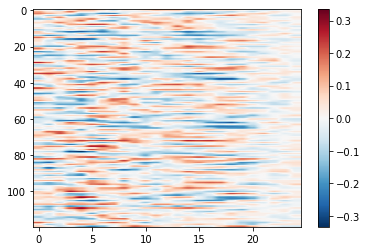

r_vals_12p5_max.head(20) =              0         1         2         3         4         5         6  \
78  -0.057745 -0.085798 -0.086483 -0.300218 -0.334251 -0.208266  0.016580   
103  0.066481  0.090679  0.063893  0.172521  0.334113  0.263290  0.038264   
16   0.059577 -0.016041 -0.194767 -0.271710 -0.330241 -0.294475 -0.071261   
109 -0.046174 -0.127862  0.048694  0.243041  0.327103  0.233883  0.134034   
38  -0.106726 -0.004648  0.093348  0.181957  0.100580 -0.074134 -0.153328   
75   0.103008  0.178475  0.164373  0.090370  0.122775  0.288189  0.275151   
87  -0.120168 -0.286823 -0.137424 -0.054236  0.029793  0.023178  0.090817   
62  -0.060377  0.011761  0.038210  0.189709  0.106890 -0.010343 -0.129308   
12   0.092763 -0.052683 -0.170803 -0.257549 -0.282725 -0.208441 -0.229709   
35   0.227131  0.240154  0.202474  0.073399  0.011561 -0.109028 -0.145720   
72   0.052805  0.067427  0.179143  0.178664  0.235819  0.213052  0.227185   
29   0.263601  0.173766 -0.022755  0.066272  0.0

In [10]:
"""
Layer 1:
Plot R^2 of 12.5 uM dataset and get colorbar which is the same scale as above logos.
Show plot number of the highest correlation filters under "original_order"
"""
plt.imshow(r_vals_12p5, cmap='RdBu_r', aspect='auto', vmin=-np.max(np.abs(r_vals_12p5)), vmax=np.max(np.abs(r_vals_12p5)))
plt.colorbar()
#plt.savefig("%s/r_vals_12p5_layer1.pdf" % (output_fig_dir))
plt.show()

r_vals_12p5_max = pd.DataFrame(r_vals_12p5)
r_vals_12p5_max["max"] = np.amax(abs(r_vals_12p5), axis=1)
r_vals_12p5_max["original_order"] = range(len(r_vals_12p5_max))
r_vals_12p5_max = r_vals_12p5_max.sort_values(by=['max'], ascending=False)
print("r_vals_12p5_max.head(20) = ", r_vals_12p5_max.head(20))


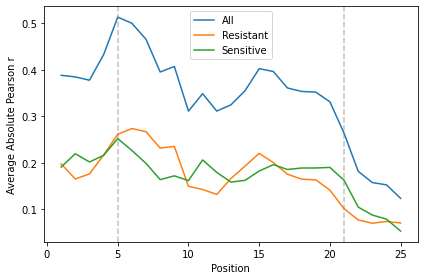

In [11]:
r_vals_12p5_pos_sum = abs(r_vals_12p5).sum(axis=0).reshape(25,1)
r_vals_12p5_pos_avg = r_vals_12p5_pos_sum /25
r_vals_12p5_pos_avg_df = pd.DataFrame(r_vals_12p5_pos_avg, columns = ["Average Absolute Pearson r"])
r_vals_12p5_pos_avg_df["Position"] = range(1, len(r_vals_12p5_pos_avg_df.index) + 1)
sns.lineplot(data=r_vals_12p5_pos_avg_df, x="Position", y="Average Absolute Pearson r")

r_vals_12p5_resistant_pos_avg = r_vals_12p5.copy()
r_vals_12p5_resistant_pos_avg[r_vals_12p5_resistant_pos_avg < 0] = 0
r_vals_12p5_resistant_pos_avg = r_vals_12p5_resistant_pos_avg.sum(axis=0).reshape(25,1) / 25
r_vals_12p5_resistant_pos_avg_df = pd.DataFrame(r_vals_12p5_resistant_pos_avg, columns = ["Average Absolute Pearson r"])
r_vals_12p5_resistant_pos_avg_df["Position"] = range(1, len(r_vals_12p5_resistant_pos_avg_df.index) + 1)
sns.lineplot(data=r_vals_12p5_resistant_pos_avg_df, x="Position", y="Average Absolute Pearson r")

r_vals_12p5_sensitive_pos_avg = r_vals_12p5.copy()
r_vals_12p5_sensitive_pos_avg[r_vals_12p5_sensitive_pos_avg > 0] = 0
r_vals_12p5_sensitive_pos_avg = abs(r_vals_12p5_sensitive_pos_avg).sum(axis=0).reshape(25,1) / 25
r_vals_12p5_sensitive_pos_avg_df = pd.DataFrame(r_vals_12p5_sensitive_pos_avg, columns = ["Average Absolute Pearson r"])
r_vals_12p5_sensitive_pos_avg_df["Position"] = range(1, len(r_vals_12p5_sensitive_pos_avg_df.index) + 1)

sns.lineplot(data=r_vals_12p5_sensitive_pos_avg_df, x="Position", y="Average Absolute Pearson r")

plt.legend(labels=["All", "Resistant", "Sensitive"])
plt.axvline(x=5, linestyle="dashed", color="gray", alpha=0.5)
plt.axvline(x=21, linestyle="dashed", color="gray", alpha=0.5)
plt.tight_layout()
plt.savefig("%s/r_vals_avg_abs_12p5_layer1.pdf" % (output_fig_dir))
plt.show()

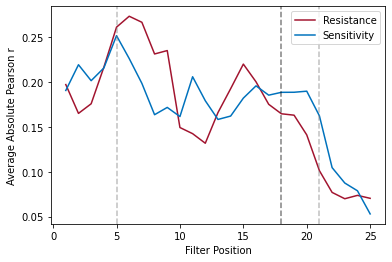

In [12]:
r_vals_12p5_resistant_pos_avg = r_vals_12p5.copy()
r_vals_12p5_resistant_pos_avg[r_vals_12p5_resistant_pos_avg < 0] = 0
r_vals_12p5_resistant_pos_avg = r_vals_12p5_resistant_pos_avg.sum(axis=0).reshape(25,1) / 25
r_vals_12p5_resistant_pos_avg_df = pd.DataFrame(r_vals_12p5_resistant_pos_avg, columns = ["Average Absolute Pearson r"])
r_vals_12p5_resistant_pos_avg_df["Filter Position"] = range(1, len(r_vals_12p5_resistant_pos_avg_df.index) + 1)
sns.lineplot(data=r_vals_12p5_resistant_pos_avg_df, x="Filter Position", y="Average Absolute Pearson r", color="#A2142F")

r_vals_12p5_sensitive_pos_avg = r_vals_12p5.copy()
r_vals_12p5_sensitive_pos_avg[r_vals_12p5_sensitive_pos_avg > 0] = 0
r_vals_12p5_sensitive_pos_avg = abs(r_vals_12p5_sensitive_pos_avg).sum(axis=0).reshape(25,1) / 25
r_vals_12p5_sensitive_pos_avg_df = pd.DataFrame(r_vals_12p5_sensitive_pos_avg, columns = ["Average Absolute Pearson r"])
r_vals_12p5_sensitive_pos_avg_df["Filter Position"] = range(1, len(r_vals_12p5_sensitive_pos_avg_df.index) + 1)

sns.lineplot(data=r_vals_12p5_sensitive_pos_avg_df, x="Filter Position", y="Average Absolute Pearson r", color="#0072BD")

plt.legend(labels=["Resistance", "Sensitivity"], loc="upper right")
plt.axvline(x=5, linestyle="dashed", color="gray", alpha=0.5)
plt.axvline(x=21, linestyle="dashed", color="gray", alpha=0.5)
plt.axvline(x=18, linestyle="dashed", color="black", alpha=0.5)
plt.savefig("%s/r_vals_avg_abs_12p5_layer1_resistance_sensitivity.pdf" % (output_fig_dir))
plt.show()

In [13]:
"""
Create new model that outputs the convolutional layer 2 activation maps together with the log(ratio) predictions
"""

conv_layer_logratio_layer2_model = Model(
    inputs = C3P0_ratios_model_SVLstonly.inputs,
    outputs = [
        C3P0_ratios_model_SVLstonly.get_layer('conv1d_31').output,
        C3P0_ratios_model_SVLstonly.get_layer('dense_21').output
    ]
)

In [14]:
"""
Predict from convolutional layer 2 activation maps model
"""

#Retrieve one-hot input sequences

ratio_conv_2_out, ratio_pred = conv_layer_logratio_layer2_model.predict(onehot_seqs, workers=4, use_multiprocessing=True)

print(ratio_conv_2_out.shape)

ratio_conv_2_out = np.reshape(ratio_conv_2_out, (ratio_conv_2_out.shape[0], ratio_conv_2_out.shape[1], ratio_conv_2_out.shape[2]))

print(onehot_seqs.shape)
print(ratio_pred)
print(ratio_conv_2_out.shape)


(100958, 25, 120)
(100958, 25, 4)
[[-0.02822695  0.04701005  0.07803788]
 [-0.07389697 -0.08124356 -0.10407057]
 [ 0.12786695  0.24233249  0.42592165]
 ...
 [-0.22552347 -0.2689769  -0.32126534]
 [ 0.1317293   0.23789236  0.43165472]
 [-0.14658639 -0.302867   -0.58694047]]
(100958, 25, 120)


In [15]:
#Layer 2: Compute Max Activation Correlation maps and PWMs, handle border_mode=same, 8 nt padding
filter_width = 15  # 8 + 8 - 1
n_samples = 5000

pwms = np.zeros((ratio_conv_2_out.shape[2], filter_width, 4))  # <num filters, filter_len, 4 nts>
pwms_top = np.zeros((ratio_conv_2_out.shape[2], filter_width, 4))

print("pwms.shape = ", pwms.shape)
print("onehot_seqs.shape = ", onehot_seqs.shape)
print("ratio_conv_2_out.shape = ", ratio_conv_2_out.shape)

filler_5 = np.zeros((7, 4))  # layer 1 filter length of 8 / 2 * 2
filler_3 = np.zeros((8, 4))  # layer 1 filter length of 8 / 2 * 2

for k in range(ratio_conv_2_out.shape[2]) :  # iterate over filters
    
    for i in range(ratio_conv_2_out.shape[0]) :  # iterate over samples
        max_j = np.argmax(ratio_conv_2_out[i, :, k])  # find max activation in seq
        if ratio_conv_2_out[i, max_j, k] > 0 :
            padded_one_hot = np.concatenate((filler_5, onehot_seqs[i, :, :], filler_3), axis=0)
            subseq_one_hot = padded_one_hot[max_j : max_j + filter_width, :]
            pwms[k, :, :] += subseq_one_hot

    sort_index = np.argsort(np.max(ratio_conv_2_out[:, :, k], axis=-1))[::-1]
    for i in range(n_samples) :  # iterate over samples that have been sorted
        max_j = np.argmax(ratio_conv_2_out[sort_index[i], :, k])
        if ratio_conv_2_out[sort_index[i], max_j, k] > 0 :
            padded_one_hot = np.concatenate((filler_5, onehot_seqs[sort_index[i], :, :], filler_3), axis=0)
            subseq_one_hot = padded_one_hot[max_j: max_j+filter_width, :]
            
            pwms_top[k, :, :] += subseq_one_hot
        
    pwms[k, :, :] /= np.expand_dims(np.sum(pwms[k, :, :], axis=-1), axis=-1)
    pwms_top[k, :, :] /= np.expand_dims(np.sum(pwms_top[k, :, :], axis=-1), axis=-1)

#print("pwms = ", pwms)
print("pwms.shape = ", pwms.shape)
print("pwms_top.shape = ", pwms_top.shape)
print("(pwms == pwms_top).all() = ", (pwms == pwms_top).all())


r_vals_12p5 = np.zeros((ratio_conv_2_out.shape[2], ratio_conv_2_out.shape[1]))
r_vals_2p5 = np.zeros((ratio_conv_2_out.shape[2], ratio_conv_2_out.shape[1]))
r_vals_0p5 = np.zeros((ratio_conv_2_out.shape[2], ratio_conv_2_out.shape[1]))

for k in range(ratio_conv_2_out.shape[2]) :  # filters
    for j in range(ratio_conv_2_out.shape[1]) :  # sequence
        if np.any(ratio_conv_2_out[:, j, k] > 0.) :
            r_val_12p5, _ = pearsonr(ratio_conv_2_out[:, j, k], ratio_pred[:,2])
            r_vals_12p5[k, j] = r_val_12p5 if not np.isnan(r_val_12p5) else 0
            r_val_2p5, _ = pearsonr(ratio_conv_2_out[:, j, k], ratio_pred[:,1])
            r_vals_2p5[k, j] = r_val_2p5 if not np.isnan(r_val_2p5) else 0
            r_val_0p5, _ = pearsonr(ratio_conv_2_out[:, j, k], ratio_pred[:,0])
            r_vals_0p5[k, j] = r_val_0p5 if not np.isnan(r_val_0p5) else 0

print("r_vals_12p5.shape = ", r_vals_12p5.shape)

pwms.shape =  (120, 15, 4)
onehot_seqs.shape =  (100958, 25, 4)
ratio_conv_2_out.shape =  (100958, 25, 120)
pwms.shape =  (120, 15, 4)
pwms_top.shape =  (120, 15, 4)
(pwms == pwms_top).all() =  False
r_vals_12p5.shape =  (120, 25)


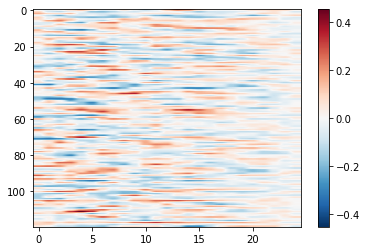

r_vals_12p5_max.head(20) =              0         1         2         3         4         5         6  \
111  0.015913  0.047098  0.093425  0.320769  0.454048  0.337652  0.056716   
70  -0.141049 -0.170367  0.022510  0.288613  0.422172  0.296155  0.088960   
55  -0.089740 -0.082165  0.056226  0.238768  0.292739  0.210956  0.181869   
22  -0.061541 -0.115574 -0.150989 -0.056999  0.000981  0.219034  0.361909   
46   0.020824  0.010768 -0.045899  0.018590  0.010501  0.103237  0.109679   
11   0.150729 -0.063712 -0.143394 -0.277469 -0.339743 -0.206905  0.035351   
94   0.058149  0.038669 -0.039244 -0.161386 -0.273178 -0.337311 -0.296503   
71  -0.302842 -0.335267 -0.306733 -0.195843 -0.073372 -0.036780 -0.056829   
66   0.232748  0.152609 -0.020584 -0.117055 -0.334258 -0.275511 -0.114123   
43   0.052573  0.181552  0.101136 -0.054965 -0.150251 -0.164681 -0.267209   
49  -0.175871 -0.329338 -0.332299 -0.306331 -0.172417 -0.014374  0.042105   
38  -0.010154  0.025321  0.242410  0.327057  0.2

In [16]:
"""
Layer 2:
Plot R^2 of 12.5 uM dataset and get colorbar which is the same scale as above logos.
Show plot number of the highest correlation filters under "original_order"
"""
plt.imshow(r_vals_12p5, cmap='RdBu_r', aspect='auto', vmin=-np.max(np.abs(r_vals_12p5)), vmax=np.max(np.abs(r_vals_12p5)))
plt.colorbar()
#plt.savefig("%s/r_vals_12p5_layer2.pdf" % (output_fig_dir))
plt.show()

r_vals_12p5_max = pd.DataFrame(r_vals_12p5)
r_vals_12p5_max["max"] = np.amax(abs(r_vals_12p5), axis=1)
r_vals_12p5_max["original_order"] = range(len(r_vals_12p5_max))
r_vals_12p5_max = r_vals_12p5_max.sort_values(by=['max'], ascending=False)
print("r_vals_12p5_max.head(20) = ", r_vals_12p5_max.head(20))


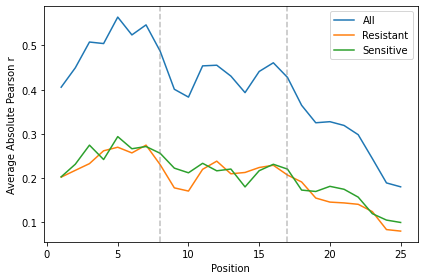

In [17]:
r_vals_12p5_pos_sum = abs(r_vals_12p5).sum(axis=0).reshape(25,1)
r_vals_12p5_pos_avg = r_vals_12p5_pos_sum /25
r_vals_12p5_pos_avg_df = pd.DataFrame(r_vals_12p5_pos_avg, columns = ["Average Absolute Pearson r"])
r_vals_12p5_pos_avg_df["Position"] = range(1, len(r_vals_12p5_pos_avg_df.index) + 1)
sns.lineplot(data=r_vals_12p5_pos_avg_df, x="Position", y="Average Absolute Pearson r")

r_vals_12p5_resistant_pos_avg = r_vals_12p5.copy()
r_vals_12p5_resistant_pos_avg[r_vals_12p5_resistant_pos_avg < 0] = 0
r_vals_12p5_resistant_pos_avg = r_vals_12p5_resistant_pos_avg.sum(axis=0).reshape(25,1) / 25
r_vals_12p5_resistant_pos_avg_df = pd.DataFrame(r_vals_12p5_resistant_pos_avg, columns = ["Average Absolute Pearson r"])
r_vals_12p5_resistant_pos_avg_df["Position"] = range(1, len(r_vals_12p5_resistant_pos_avg_df.index) + 1)
sns.lineplot(data=r_vals_12p5_resistant_pos_avg_df, x="Position", y="Average Absolute Pearson r")

r_vals_12p5_sensitive_pos_avg = r_vals_12p5.copy()
r_vals_12p5_sensitive_pos_avg[r_vals_12p5_sensitive_pos_avg > 0] = 0
r_vals_12p5_sensitive_pos_avg = abs(r_vals_12p5_sensitive_pos_avg).sum(axis=0).reshape(25,1) / 25
r_vals_12p5_sensitive_pos_avg_df = pd.DataFrame(r_vals_12p5_sensitive_pos_avg, columns = ["Average Absolute Pearson r"])
r_vals_12p5_sensitive_pos_avg_df["Position"] = range(1, len(r_vals_12p5_sensitive_pos_avg_df.index) + 1)

sns.lineplot(data=r_vals_12p5_sensitive_pos_avg_df, x="Position", y="Average Absolute Pearson r")
plt.axvline(x=8, linestyle="dashed", color="gray", alpha=0.5)
plt.axvline(x=17, linestyle="dashed", color="gray", alpha=0.5)
plt.legend(labels=["All", "Resistant", "Sensitive"])
plt.tight_layout()
plt.savefig("%s/r_vals_avg_abs_12p5_layer2.pdf" % (output_fig_dir))
plt.show()